<a href="https://colab.research.google.com/github/Swelem/obesity_risk/blob/main/Checkpoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preparation

## Download and unzip

In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import os
import glob
#import optuna
ran_optuna = False
from tqdm import tqdm
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import random
from PIL import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder,PowerTransformer
from imblearn.over_sampling import SMOTE
#from optuna.samplers import TPESampler

import torch
from torch import nn
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader



In [3]:
!pip install -q kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saifswelem","key":"93c4723ccbde8c247af262277f428b4b"}'}

In [5]:
!mkdir -p ~/.kaggle

In [6]:

!mkdir /content/Dataset

In [7]:
!cp kaggle.json ~/.kaggle/

In [8]:
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
import os
os.chdir('/content/Dataset')

In [10]:
!kaggle competitions download -c playground-series-s4e2


  0% 0.00/917k [00:00<?, ?B/s]
100% 917k/917k [00:00<00:00, 45.2MB/s]


In [11]:
!unzip playground-series-s4e2.zip

Archive:  playground-series-s4e2.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [12]:
given_test_data = pd.read_csv('/content/Dataset/test.csv')


given_train_data = pd.read_csv('/content/Dataset/train.csv')

## Data Exploration

In [13]:
given_train_data.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [14]:
given_test_data.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,20758,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,2.825629,no,0.855400,0.000000,Sometimes,Public_Transportation
1,20759,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Public_Transportation
2,20760,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,2.621877,no,0.000000,0.250502,Sometimes,Public_Transportation
3,20761,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,2.786417,no,0.094851,0.000000,Sometimes,Public_Transportation
4,20762,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,2.653531,no,0.000000,0.741069,Sometimes,Public_Transportation


In [17]:
print(given_train_data.shape)
print(given_test_data.shape)

(20758, 18)
(13840, 17)


In [21]:
print(given_train_data["NObeyesdad"].unique())
class_counts = given_train_data["NObeyesdad"].value_counts()
class_counts

['Overweight_Level_II' 'Normal_Weight' 'Insufficient_Weight'
 'Obesity_Type_III' 'Obesity_Type_II' 'Overweight_Level_I'
 'Obesity_Type_I']


NObeyesdad
Obesity_Type_III       4046
Obesity_Type_II        3248
Normal_Weight          3082
Obesity_Type_I         2910
Insufficient_Weight    2523
Overweight_Level_II    2522
Overweight_Level_I     2427
Name: count, dtype: int64

## Data Visualization


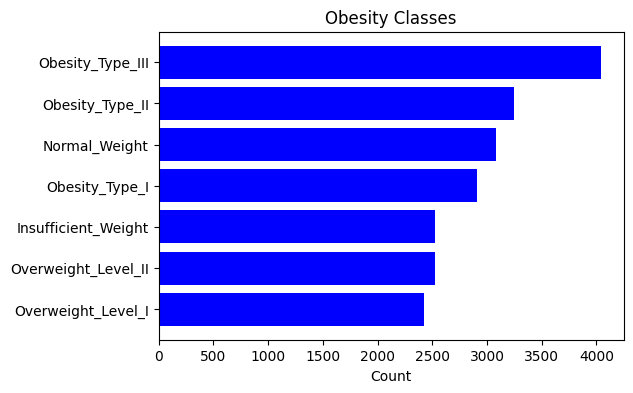

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.barh(class_counts.index, class_counts.values, color="blue")
plt.xlabel("Count")
plt.title("Obesity Classes")
plt.gca().invert_yaxis() ## Invert the y-axis to show the highest frequency class at the top
plt.show()

In [23]:
categorical_features = given_train_data.select_dtypes(include=['object']).columns
continuous_features = given_train_data.select_dtypes(include=['float64','int64']).columns
## Export categorical and continuous data to separate DataFrames

data_cat = given_train_data[categorical_features]
data_cont = given_train_data[continuous_features]
print(data_cat.columns)
print(data_cont.columns)

Index(['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
       'SCC', 'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object')
Index(['id', 'Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'], dtype='object')


In [24]:
data_id= data_cont["id"]
data_cont.drop('id',axis=1, inplace=True)

<ipython-input-24-6bfb34d38753>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cont.drop('id',axis=1, inplace=True)


<ipython-input-25-96516fd721f9>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data_cat[col], ax=axes[i], palette='viridis')
<ipython-input-25-96516fd721f9>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data_cat[col], ax=axes[i], palette='viridis')
<ipython-input-25-96516fd721f9>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data_cat[col], ax=axes[i], palette='viridis')
<ipython-input-25-96516fd721f9>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the

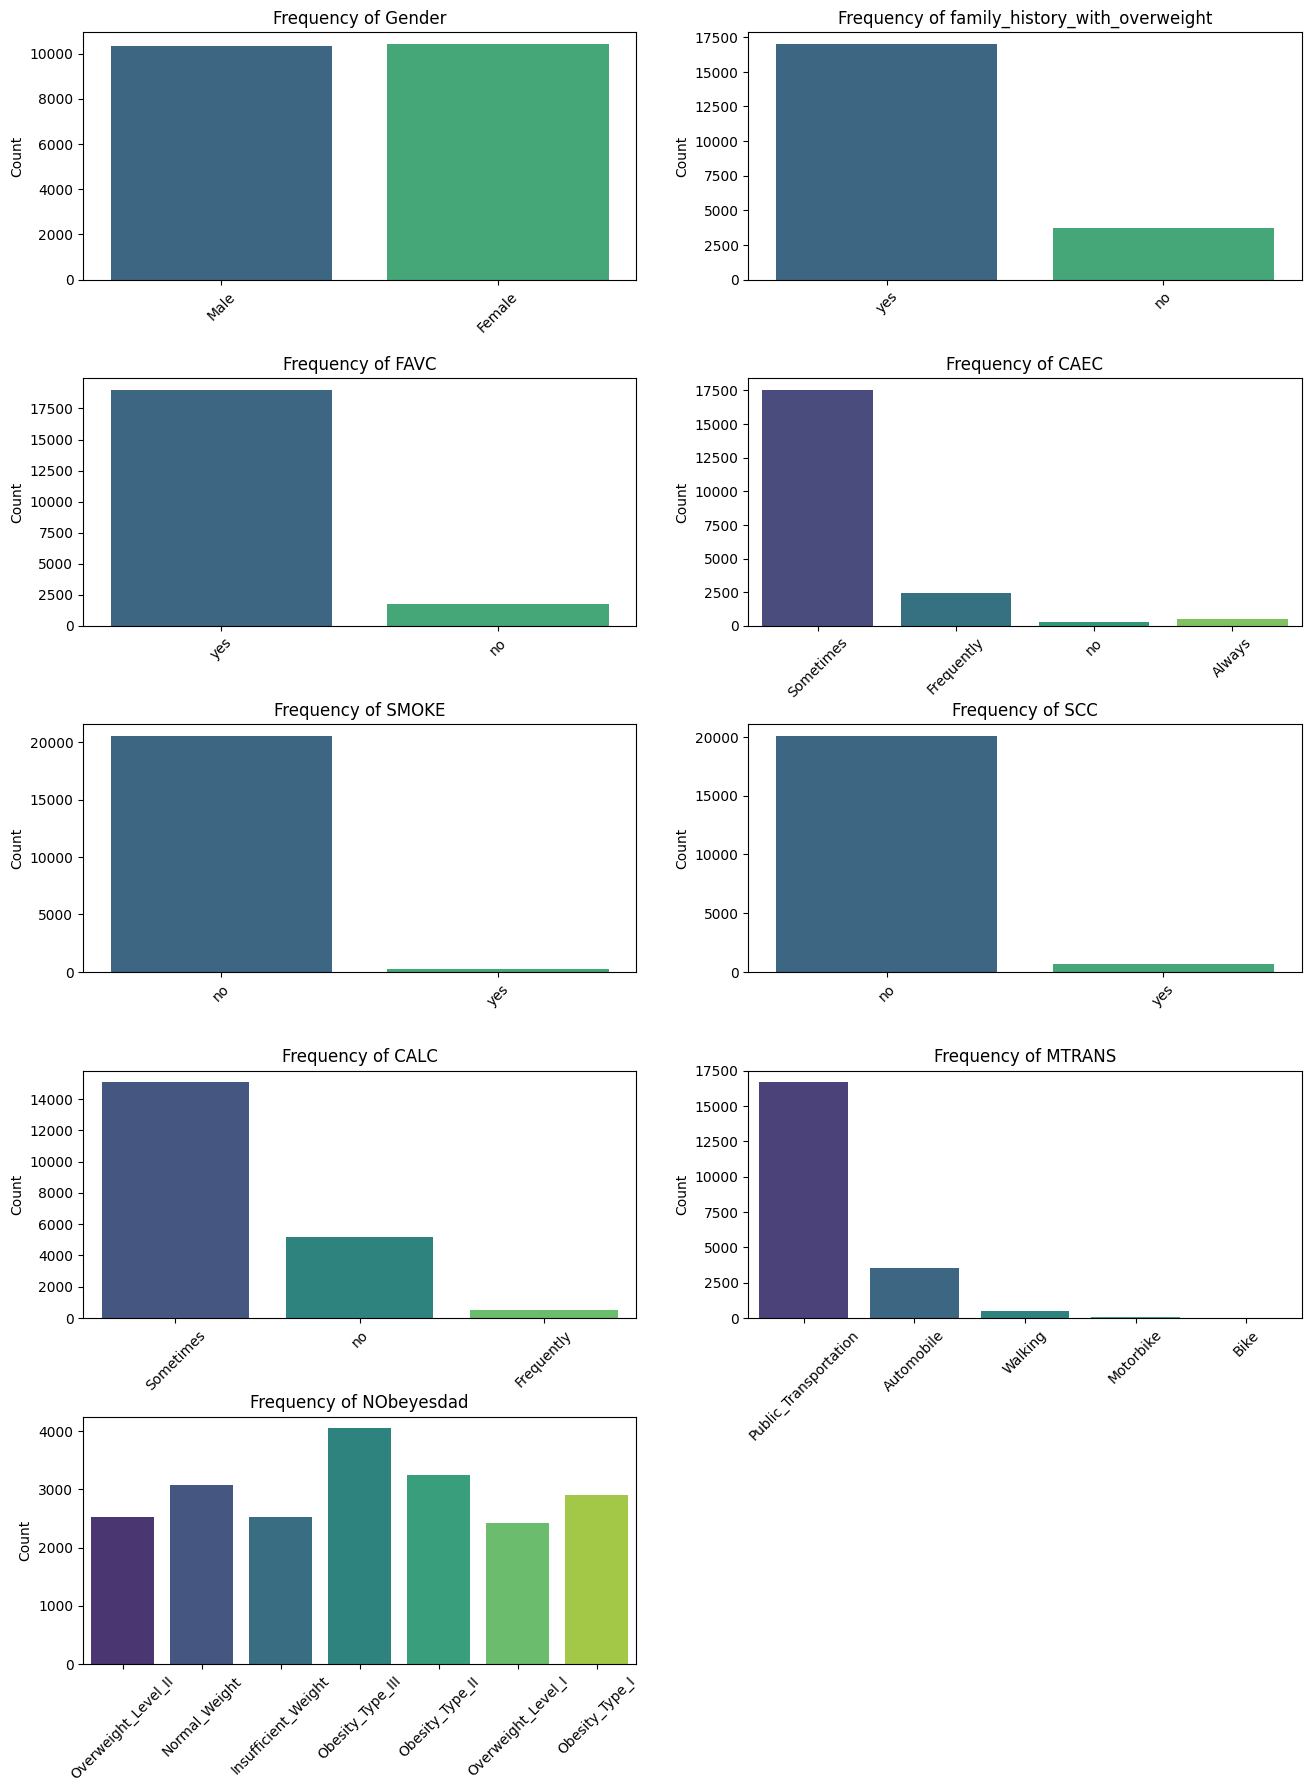

In [25]:
import seaborn as sns

## Drawing a frequency graph for each categorical variable
fig, axes = plt.subplots(nrows=(len(data_cat.columns)+1) // 2, ncols=2,figsize=(14, len(data_cat.columns) * 2))
fig.tight_layout(pad=5.0)

## Adjustment for proper positioning of the axes
axes = axes.ravel()

for i, col in enumerate(data_cat.columns):
    sns.countplot(x=data_cat[col], ax=axes[i], palette='viridis')
    axes[i].set_title(f'Frequency of {col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

## Closing extra created axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.show()

## Data Preprocessing

In [80]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [81]:
# Add BMI column
df_train['BMI'] = df_train['Weight'] / (df_train['Height']) ** 2
df_test['BMI'] = df_test['Weight'] / (df_test['Height']) ** 2

In [75]:
# Check for missing values
print(df_train.isnull().sum())

id                                0
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
BMI                               0
dtype: int64


In [76]:
print(df_test.isnull().sum())

id                                0
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
BMI                               0
dtype: int64


In [82]:
# Define function to round column
def round_column(df: pd.DataFrame,
                 column: str,
                 n_decimals: int = 0) -> pd.DataFrame:

    df[column] = df[column].round(n_decimals)
    return df

# Round columns 'FCVC' and 'NCP' to 1 decimal
df_train = round_column(df_train, 'FCVC')
df_train = round_column(df_train, 'NCP')
df_test = round_column(df_test, 'FCVC')
df_test = round_column(df_test, 'NCP')

# print unique values of 'FCVC' and 'NCP' for train dataset
print(f'{np.unique(df_train["FCVC"]) = }')
print(f'{np.unique(df_train["NCP"]) = }')

# print unique values of 'FCVC' and 'NCP' for test dataset
print(f'{np.unique(df_test["FCVC"]) = }')
print(f'{np.unique(df_test["NCP"]) = }')

np.unique(df_train["FCVC"]) = array([1., 2., 3.])
np.unique(df_train["NCP"]) = array([1., 2., 3., 4.])
np.unique(df_test["FCVC"]) = array([1., 2., 3.])
np.unique(df_test["NCP"]) = array([1., 2., 3., 4.])


In [69]:
# Check for missing values
print(df_train.isnull().sum())

id                                0
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
BMI                               0
dtype: int64


In [70]:
# convert Gender to binary
df_train['Gender'] = df_train['Gender'].map({'Male': 1, 'Female': 0})
df_test['Gender'] = df_test['Gender'].map({'Male': 1, 'Female': 0})

# convert age to categorical
age_mapping = {'0-18': 0, '18-30': 1, '30-40': 2, '40-50': 3, '50-60': 4, '60-70': 5, '70-80': 6}
df_train['Age'] = df_train['Age'].map(age_mapping)
df_test['Age'] = df_train['Age'].map(age_mapping)

df_train['Age'] = pd.cut(df_train['Age'], bins=[0, 18, 30, 40, 50, 60, 70, 80], labels=['0-18', '18-30', '30-40', '40-50', '50-60', '60-70', '70-80'])
df_test['Age'] = pd.cut(df_test['Age'], bins=[0, 18, 30, 40, 50, 60, 70, 80], labels=['0-18', '18-30', '30-40', '40-50', '50-60', '60-70', '70-80'])

# convert BMI to categorical
df_train['BMI'] = pd.to_numeric(df_train['BMI'], errors='coerce')
df_test['BMI'] = pd.to_numeric(df_train['BMI'], errors='coerce')

df_train['BMI'] = pd.cut(df_train['BMI'], bins=[0, 18.5, 25, 30, 35, 40, 60], labels=['Underweight', 'Normal', 'Overweight', 'Obesity I', 'Obesity II', 'Obesity III'])
df_test['BMI'] = pd.cut(df_test['BMI'], bins=[0, 18.5, 25, 30, 35, 40, 60], labels=['Underweight', 'Normal', 'Overweight', 'Obesity I', 'Obesity II', 'Obesity III'])

# convert family_history_with_overweight to binary (yes=1, no=0)
df_train['family_history_with_overweight'] = df_train['family_history_with_overweight'].map({'yes': 1, 'no': 0})
df_test['family_history_with_overweight'] = df_test['family_history_with_overweight'].map({'yes': 1, 'no': 0})

# convert SMOKE to binary (yes=1, no=0)
df_train['SMOKE'] = df_train['SMOKE'].map({'yes': 1, 'no': 0})
df_test['SMOKE'] = df_test['SMOKE'].map({'yes': 1, 'no': 0})

# convert SCC to binary (yes=1, no=0)
df_train['SCC'] = df_train['SCC'].map({'yes': 1, 'no': 0})
df_test['SCC'] = df_test['SCC'].map({'yes': 1, 'no': 0})

# convert FAVC to binary (yes=1, no=0)
df_train['FAVC'] = df_train['FAVC'].map({'yes': 1, 'no': 0})
df_test['FAVC'] = df_test['FAVC'].map({'yes': 1, 'no': 0})

# convert CALC to binary (always=3, frequently=2, sometimes=1, no=0)
df_train['CALC'] = df_train['CALC'].map({'Always': 3, 'Frequently': 2, 'Sometimes': 1, 'no': 0})
df_test['CALC'] = df_test['CALC'].map({'Always': 3, 'Frequently': 2, 'Sometimes': 1, 'no': 0})

# convert CAEC to binary (no=0, Sometimes=1, Frequently=2, Always=3)
df_train['CAEC'] = df_train['CAEC'].map({'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3})
df_test['CAEC'] = df_test['CAEC'].map({'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3})

# convert MTRANS to dummy variables with fusioning motobike and bike into automobile
df_train = pd.get_dummies(df_train, columns=['MTRANS'])
df_test = pd.get_dummies(df_test, columns=['MTRANS'])

# round CH2O to 0 decimals
df_train = round_column(df_train, 'CH2O')
df_test = round_column(df_test, 'CH2O')

# round TUE to 1 decimal
df_train = round_column(df_train, 'TUE', n_decimals=1)
df_test = round_column(df_test, 'TUE', n_decimals=1)

# round FAF to 1 decimal
df_train = round_column(df_train, 'FAF', n_decimals=1)
df_test = round_column(df_test, 'FAF', n_decimals=1)

# Put BMI and Age to numerical values
df_train['BMI'] = df_train['BMI'].cat.codes
df_train['Age'] = df_train['Age'].cat.codes
df_test['BMI'] = df_test['BMI'].cat.codes
df_test['Age'] = df_test['Age'].cat.codes

# delete height and weight columns
# df_train = df_train.drop(['Height', 'Weight'], axis=1)
# df_test = df_test.drop(['Height', 'Weight'], axis=1)

# Add polynomial features
polynomial_features = PolynomialFeatures(degree=2, include_bias=False)
X_polynomial = polynomial_features.fit_transform(df_train[['Age', 'BMI']])
df_train.drop(['Age', 'BMI'], axis=1, inplace=True)
df_train = pd.concat([df_train, pd.DataFrame(X_polynomial, columns=['Age', 'BMI', 'Age^2', 'Age*BMI', 'BMI^2'])], axis=1)
X_polynomial2 = polynomial_features.fit_transform(df_train[['Weight', 'Height']])
df_train.drop(['Weight', 'Height'], axis=1, inplace=True)
df_train = pd.concat([df_train, pd.DataFrame(X_polynomial2, columns=['Weight', 'Height', 'Weight^2', 'Weight*Height', 'Height^2'])], axis=1)

X_polynomial = polynomial_features.fit_transform(df_test[['Age', 'BMI']])
df_test.drop(['Age', 'BMI'], axis=1, inplace=True)
df_test = pd.concat([df_test, pd.DataFrame(X_polynomial, columns=['Age', 'BMI', 'Age^2', 'Age*BMI', 'BMI^2'])], axis=1)
X_polynomial2 = polynomial_features.fit_transform(df_test[['Weight', 'Height']])
df_test.drop(['Weight', 'Height'], axis=1, inplace=True)
df_test = pd.concat([df_test, pd.DataFrame(X_polynomial2, columns=['Weight', 'Height', 'Weight^2', 'Weight*Height', 'Height^2'])], axis=1)

In [36]:
# convert NObeyesdad to numerical values
df_train['NObeyesdad'] = df_train['NObeyesdad'].map({'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Overweight_Level_I': 2, 'Overweight_Level_II': 3, 'Obesity_Type_I': 4, 'Obesity_Type_II': 5, 'Obesity_Type_III': 6})

In [84]:
# columns=['Gender','family_history_with_overweight','FAVC','SMOKE','SCC']
# df_train=pd.get_dummies(df_train,columns=columns,drop_first=True,dtype=int)
# df_test=pd.get_dummies(df_test,columns=columns,drop_first=True,dtype=int)


# le=LabelEncoder()
# a=['CAEC','CALC','MTRANS']
# for i in a:
#     df_train[i]=le.fit_transform(df_train[i])
#     df_test[i]=le.fit_transform(df_test[i])

# df_train['NObeyesdad']=le.fit_transform(df_train['NObeyesdad'])

In [87]:
# pt = PowerTransformer(method='yeo-johnson')
# train_features = df_train.drop('NObeyesdad', axis=1)
# train_features_scaled = pt.fit_transform(train_features)

# train_scaled = pd.DataFrame(train_features_scaled, columns=train_features.columns)
# train_scaled['NObeyesdad'] = df_train['NObeyesdad']

In [88]:
# def remove_outliers(data):
#     Q1 = data.quantile(0.25)
#     Q3 = data.quantile(0.75)
#     IQR = Q3 - Q1
#     data = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]
#     return data

# train_scaled = remove_outliers(train_scaled)

In [89]:
# b=['CALC','NCP']
# for i in b:
#     df_train=df_train.drop(i,axis=1)

In [98]:
X = train_scaled.drop('NObeyesdad', axis=1)
y = train_scaled['NObeyesdad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
# Check for missing values
print(df_train.isnull().sum())

id                                0
Gender                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
NObeyesdad                        0
MTRANS_Automobile                 0
MTRANS_Bike                       0
MTRANS_Motorbike                  0
MTRANS_Public_Transportation      0
MTRANS_Walking                    0
Age                               0
BMI                               0
Age^2                             0
Age*BMI                           0
BMI^2                             0
Weight                            0
Height                            0
Weight^2                          0
Weight*Height               

In [38]:
df_train

,id,Gender,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,...,Age,BMI,Age^2,Age*BMI,BMI^2,Weight,Height,Weight^2,Weight*Height,Height^2
0,0,1,1,1,2.0,3.0,1,0,3.0,0,...,-1.0,2.0,1.0,-2.0,4.0,81.669950,1.699998,6669.980733,138.838752,2.889993
1,1,0,1,1,2.0,3.0,2,0,2.0,0,...,-1.0,1.0,1.0,-1.0,1.0,57.000000,1.560000,3249.000000,88.920000,2.433600
2,2,0,1,1,2.0,1.0,1,0,2.0,0,...,-1.0,0.0,1.0,-0.0,0.0,50.165754,1.711460,2516.602874,85.856681,2.929095
3,3,0,1,1,3.0,3.0,1,0,2.0,0,...,-1.0,5.0,1.0,-5.0,25.0,131.274851,1.710730,17233.086505,224.575826,2.926597
4,4,1,1,1,3.0,2.0,1,0,2.0,0,...,-1.0,2.0,1.0,-2.0,4.0,93.798055,1.914186,8798.075122,179.546924,3.664108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,20753,1,1,1,3.0,3.0,1,0,2.0,0,...,-1.0,4.0,1.0,-4.0,16.0,114.187096,1.766626,13038.692893,201.725893,3.120967
20754,20754,1,0,1,3.0,4.0,2,0,1.0,0,...,-1.0,0.0,1.0,-0.0,0.0,50.000000,1.710000,2500.000000,85.500000,2.924100
20755,20755,1,1,1,2.0,3.0,1,0,2.0,0,...,-1.0,3.0,1.0,-3.0,9.0,105.580491,1.819557,11147.240080,192.109721,3.310788
20756,20756,1,1,1,3.0,2.0,1,0,2.0,0,...,-1.0,2.0,1.0,-2.0,4.0,83.520113,1.700000,6975.609276,141.984192,2.890000


In [39]:
# Apply SMOTE to balance the dataset
X_train = df_train.drop(columns=['NObeyesdad'])
y_train = df_train['NObeyesdad']

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Create a new dataframe with the balanced dataset
df_train = pd.concat([X_train, y_train], axis=1)

In [40]:
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized confusion matrix'
    else:
        title = 'Confusion matrix, without normalization'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Compute confusion matrix manually
def compute_confusion_matrix(y_true, y_pred, classes):
    num_classes = len(classes)
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for true_label, pred_label in zip(y_true, y_pred):
        cm[true_label, pred_label] += 1
    return cm




# Round 1 Models

In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score


In [42]:
X = df_train.drop(['NObeyesdad', 'id'], axis=1)
y = df_train['NObeyesdad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
models = [
    ##('DecisionTree', DecisionTreeClassifier(random_state=42)),
    ('RandomForest', RandomForestClassifier(random_state=42)),
    ('GradientBoost', GradientBoostingClassifier(random_state=42)),
    ##('LogisticRegression', LogisticRegression(max_iter=1000, random_state=42)),
    ##('SVM', SVC(random_state=42)),
    ##('KNN', KNeighborsClassifier()),
    ('XGBoost', XGBClassifier(random_state=42))
]
best_model = None
best_accuracy = 0

for name, model in models:
    model.fit(X_train, y_train)  # Assuming X_train and y_train are your training data
    accuracy = model.score(X_test, y_test)  # Assuming X_test and y_test are your test data
    print(f"{name} Accuracy: {accuracy:.4f}")
    classes = model.classes_

    # Assuming you have computed y_pred using your RandomForestClassifier
    cm = compute_confusion_matrix(y_test, y_pred, classes)

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    plot_confusion_matrix(cm, classes=classes)
    plt.show()

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model



RandomForest Accuracy: 0.8879


NameError: name 'y_pred' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Usage example:
# plot learning curve
plot_learning_curve(best_model, "Learning Curve", X_train, y_train, cv=5)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curve(estimator, title, X_train, y_train, X_test, y_test, ylim=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the training and test learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X_train : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y_train : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X_train for classification or regression.

    X_test : array-like, shape (n_samples, n_features)
        Test vector, where n_samples is the number of samples and
        n_features is the number of features.

    y_test : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X_test for classification or regression.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise, it is interpreted as absolute sizes of the training sets.
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes_abs = np.int32(np.ceil(train_sizes * len(X_train)))
    train_scores = []
    test_scores = []

    for train_size in train_sizes_abs:
        estimator.fit(X_train[:train_size], y_train[:train_size])
        train_score = estimator.score(X_train[:train_size], y_train[:train_size])
        test_score = estimator.score(X_test, y_test)
        train_scores.append(train_score)
        test_scores.append(test_score)

    plt.plot(train_sizes_abs, train_scores, 'o-', color="r", label="Training score")
    plt.plot(train_sizes_abs, test_scores, 'o-', color="g", label="Test score")
    plt.legend(loc="best")
    return plt

# Usage example:
# plot learning curve
plot_learning_curve(best_model, "Learning Curve", X_train, y_train, X_test, y_test)
plt.show()


# Round 2 Models

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score


In [44]:
models = [
    ##('DecisionTree', DecisionTreeClassifier(random_state=42)),
    ('RandomForest', RandomForestClassifier(random_state=42)),
    ('GradientBoost', GradientBoostingClassifier(random_state=42)),
    ##('LogisticRegression', LogisticRegression(max_iter=1000, random_state=42)),
    ##('SVM', SVC(random_state=42)),
    ##('KNN', KNeighborsClassifier()),
    ('XGBoost', XGBClassifier(random_state=42))
]

# Step 9: Evaluate models using cross-validation
best_model = None
best_accuracy = 0
for name, model in models:
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    mean_accuracy = scores.mean()
    print(f"{name} Mean Accuracy: {mean_accuracy:.4f}")
    if mean_accuracy > best_accuracy:
        best_accuracy = mean_accuracy
        best_model = model

RandomForest Mean Accuracy: 0.8949
GradientBoost Mean Accuracy: 0.8889
XGBoost Mean Accuracy: 0.8991


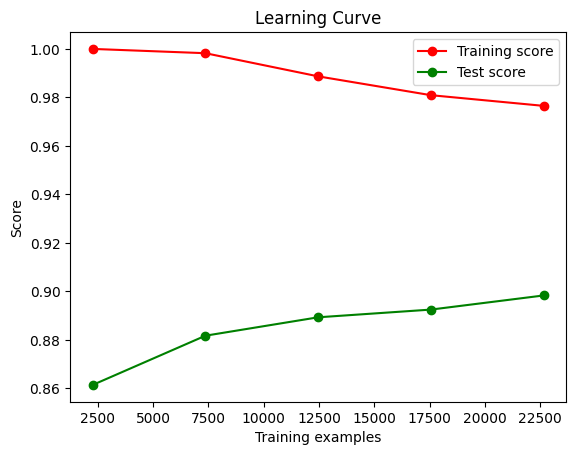

In [45]:
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curve(estimator, title, X_train, y_train, X_test, y_test, ylim=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the training and test learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X_train : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y_train : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X_train for classification or regression.

    X_test : array-like, shape (n_samples, n_features)
        Test vector, where n_samples is the number of samples and
        n_features is the number of features.

    y_test : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X_test for classification or regression.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise, it is interpreted as absolute sizes of the training sets.
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes_abs = np.int32(np.ceil(train_sizes * len(X_train)))
    train_scores = []
    test_scores = []

    for train_size in train_sizes_abs:
        estimator.fit(X_train[:train_size], y_train[:train_size])
        train_score = estimator.score(X_train[:train_size], y_train[:train_size])
        test_score = estimator.score(X_test, y_test)
        train_scores.append(train_score)
        test_scores.append(test_score)

    plt.plot(train_sizes_abs, train_scores, 'o-', color="r", label="Training score")
    plt.plot(train_sizes_abs, test_scores, 'o-', color="g", label="Test score")
    plt.legend(loc="best")
    return plt

# Usage example:
# plot learning curve
plot_learning_curve(best_model, "Learning Curve", X_train, y_train, X_test, y_test)
plt.show()


#Round 3 Models

              precision    recall  f1-score   support

           0       0.97      0.93      0.95        41
           1       0.89      0.93      0.91        91
           2       0.89      0.88      0.89       124
           3       0.98      0.99      0.99       333
           4       1.00      1.00      1.00       786
           5       0.81      0.80      0.81       106
           6       0.80      0.76      0.78        91

    accuracy                           0.95      1572
   macro avg       0.91      0.90      0.90      1572
weighted avg       0.95      0.95      0.95      1572



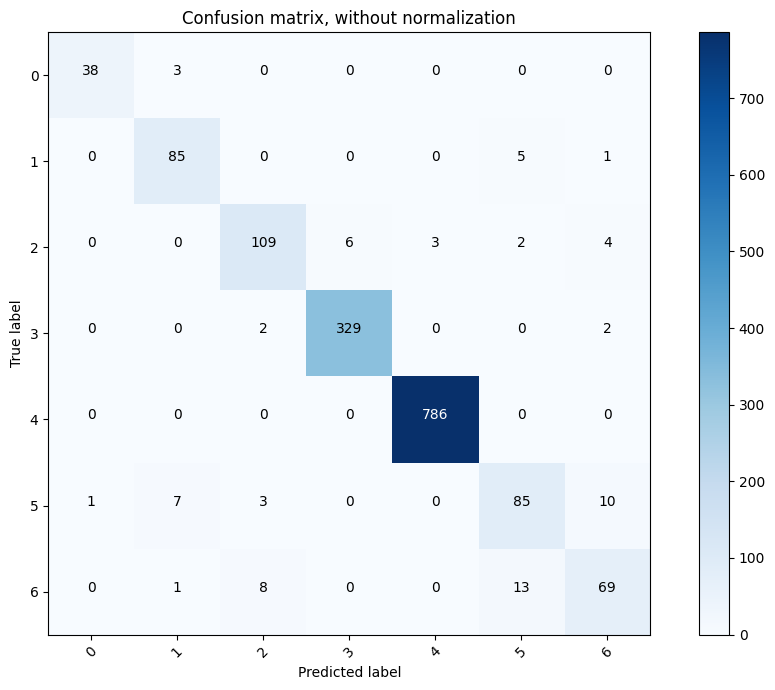

In [92]:
#X = df_train.drop(['NObeyesdad', 'id'], axis=1)
#y = df_train['NObeyesdad']

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(random_state=42, max_depth=20, n_estimators=800, criterion='gini')
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

# Plot confusion matrix
#ax = plt.subplot(1, 1, 1)
#_ = utilities.plot_confusion_matrix_heatmap(ax, y_test, y_pred)
#from sklearn.metrics import plot_confusion_matrix

# Plot confusion matrix
#plt.figure(figsize=(10, 7))
#plot_confusion_matrix(rf, X_test, y_test, ax=plt.gca(), cmap=plt.cm.Blues, values_format='.0f')
#plt.show()
# Assuming you have defined rf.classes_ as the list of class labels in your RandomForestClassifier
classes = rf.classes_

# Assuming you have computed y_pred using your RandomForestClassifier
cm = compute_confusion_matrix(y_test, y_pred, classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
plot_confusion_matrix(cm, classes=classes)
plt.show()

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        41
           1       0.91      0.92      0.92        91
           2       0.88      0.85      0.87       124
           3       0.98      0.98      0.98       333
           4       0.99      1.00      1.00       786
           5       0.81      0.82      0.81       106
           6       0.81      0.77      0.79        91

    accuracy                           0.95      1572
   macro avg       0.91      0.90      0.90      1572
weighted avg       0.95      0.95      0.95      1572



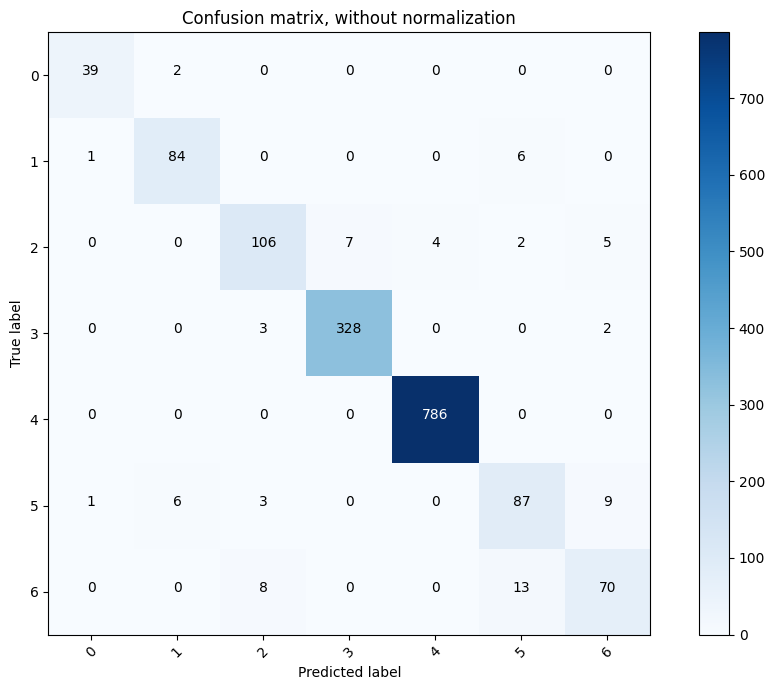

In [91]:
# Xgboost
from xgboost import XGBClassifier


best_params = {
    'grow_policy': 'depthwise',
    'n_estimators': 1318,
    'learning_rate': 0.06854096966928382,
    'gamma': 0.6829197356513476,
    'subsample': 0.8942042552212566,
    'colsample_bytree': 0.32036152443164206,
    'max_depth': 18,
    'min_child_weight': 10,
    'reg_lambda': 4.33935436979607e-05,
    'reg_alpha': 0.00014155585622193723
}
best_params['booster'] = 'gbtree'
best_params['objective'] = 'multi:softmax'
best_params["verbosity"] = 0

xgb = XGBClassifier(**best_params)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred))

# Assuming you have defined rf.classes_ as the list of class labels in your RandomForestClassifier
classes = xgb.classes_

# Assuming you have computed y_pred using your RandomForestClassifier
cm = compute_confusion_matrix(y_test, y_pred, classes)

# Plot confusion matrix
#plt.figure(figsize=(10, 7))
#ax = plt.subplot(1, 1, 1)
#_ = utilities.plot_confusion_matrix_heatmap(ax, y_test, y_pred, cmap='Reds')
plt.figure(figsize=(10, 7))
plot_confusion_matrix(cm, classes=xgb.classes_)
plt.show()

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        41
           1       0.89      0.91      0.90        91
           2       0.86      0.86      0.86       124
           3       0.98      0.98      0.98       333
           4       1.00      1.00      1.00       786
           5       0.83      0.77      0.80       106
           6       0.75      0.78      0.76        91

    accuracy                           0.95      1572
   macro avg       0.89      0.89      0.89      1572
weighted avg       0.95      0.95      0.95      1572



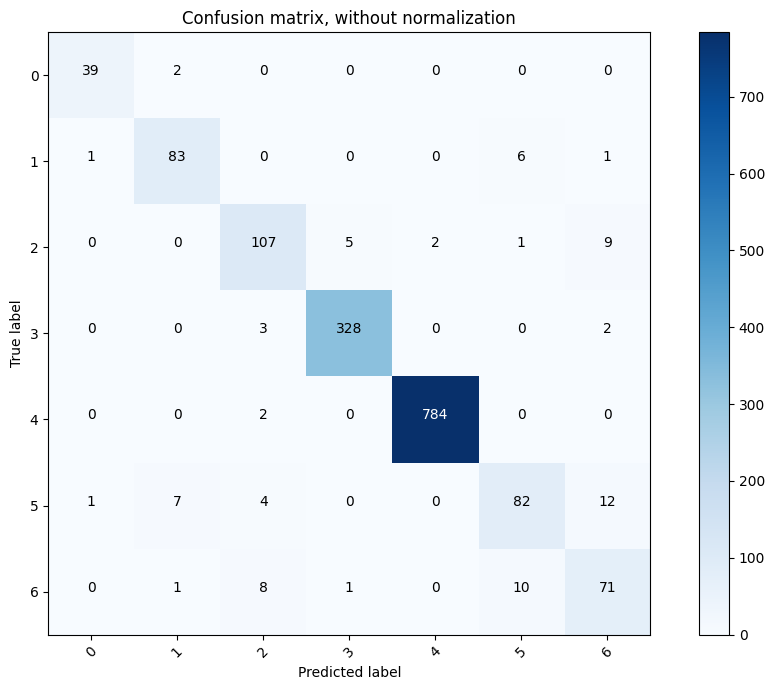

In [93]:
from sklearn.ensemble import GradientBoostingClassifier

best_params = {
    'n_estimators': 100,  # Change according to your choice
    'learning_rate': 0.1,  # Change according to your choice
    'subsample': 1.0,  # Change according to your choice
    'min_samples_split': 2,  # Change according to your choice
    'min_samples_leaf': 1,  # Change according to your choice
    'max_depth': 3,  # Change according to your choice
    'max_features': None,  # Change according to your choice
}

gradient_boost = GradientBoostingClassifier(**best_params)
gradient_boost.fit(X_train, y_train)

y_pred = gradient_boost.predict(X_test)
print(classification_report(y_test, y_pred))

# Assuming you have defined rf.classes_ as the list of class labels in your RandomForestClassifier
classes = gradient_boost.classes_

# Assuming you have computed y_pred using your RandomForestClassifier
cm = compute_confusion_matrix(y_test, y_pred, classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
plot_confusion_matrix(cm, classes=gradient_boost.classes_)
plt.show()


In [49]:
print(df_test.isnull().sum())

id                                0
Gender                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS_Automobile                 0
MTRANS_Bike                       0
MTRANS_Motorbike                  0
MTRANS_Public_Transportation      0
MTRANS_Walking                    0
Age                               0
BMI                               0
Age^2                             0
Age*BMI                           0
BMI^2                             0
Weight                            0
Height                            0
Weight^2                          0
Weight*Height                     0
Height^2                    

In [100]:
label_encoder_target = LabelEncoder()
le = LabelEncoder()

In [101]:
y_test_label = xgb.predict(X_test)

display(len(y_test_label))

df_test['NObeyesdad'] = y_test_label
out = df_test[['id','NObeyesdad']]
out.NObeyesdad = le.inverse_transform(out.NObeyesdad)
display(out.head(5))

out.to_csv("submission_non_threshold_opt.csv",index=False)

1572

ValueError: Length of values (1572) does not match length of index (13840)

In [94]:
# Step 12: Make predictions on the test data
test_predictions = xgb.predict(df_test.drop(['id'], axis=1))

# Step 13: Prepare the submission file
submission_df = pd.DataFrame({'id': df_test['id'], 'NObeyesdad': label_encoder_target.inverse_transform(test_predictions)})
submission_df.to_csv('submission.csv', index=False)

ValueError: feature_names mismatch: ['id', 'Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CAEC', 'CH2O', 'FAF', 'TUE', 'CALC', 'MTRANS', 'BMI', 'Gender_Male', 'family_history_with_overweight_yes', 'FAVC_yes', 'SMOKE_yes', 'SCC_yes'] ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CAEC', 'CH2O', 'FAF', 'TUE', 'CALC', 'MTRANS', 'BMI', 'Gender_Male', 'family_history_with_overweight_yes', 'FAVC_yes', 'SMOKE_yes', 'SCC_yes']
expected id in input data